# Simple LSTM Model

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

In [2]:
# Load the dataset
train_x = pd.read_csv('/Users/mohanyang/Documents/GitHub/SUROP_time_series/SUROP/data/train_x.csv')
train_y = pd.read_csv('/Users/mohanyang/Documents/GitHub/SUROP_time_series/SUROP/data/train_y.csv')
test_x = pd.read_csv('/Users/mohanyang/Documents/GitHub/SUROP_time_series/SUROP/data/test_x.csv')

In [3]:
# Display the first few rows
print(train_x.head())
print(train_x.shape)

   Hour  ID    Age  Gender  Unit1  Unit2     HR   O2Sat   Temp     SBP  ...  \
0     1   2  66.67     1.0    0.0    1.0  74.78  100.06  35.61  121.68  ...   
1     2   2  66.67     1.0    0.0    1.0  74.78  100.06  35.61  121.68  ...   
2     3   2  66.67     1.0    0.0    1.0  74.78  100.06  35.61  121.68  ...   
3     4   2  66.67     1.0    0.0    1.0  74.78  100.06  35.61  121.68  ...   
4     5   2  66.67     1.0    0.0    1.0  84.42   99.58  35.61  114.60  ...   

   Phosphate  Potassium  Bilirubin_total  TroponinI    Hct   Hgb  PTT   WBC  \
0        NaN       4.48              NaN        NaN  28.83  9.21  NaN  8.15   
1        NaN       4.48              NaN        NaN  28.83  9.21  NaN  8.15   
2        NaN       4.48              NaN        NaN  28.83  9.21  NaN  8.15   
3        NaN       4.48              NaN        NaN  28.83  9.21  NaN  8.15   
4        NaN       4.48              NaN        NaN  28.83  9.21  NaN  8.15   

   Fibrinogen  Platelets  
0         NaN        Na

In [4]:
print(train_y.head())
print(train_y.shape)

   ID  Outcome
0   2        0
1   3        0
2   5        1
3   6        0
4  13        0
(12115, 2)


In [5]:
max_hours = train_x.groupby('ID')['Hour'].count().max()
print(f'Maximum number of hours: {max_hours}')

Maximum number of hours: 336


In [6]:
# Get unique person IDs
person_ids = train_x['ID'].unique()

# Initialize tensors for features, masks, and time intervals
num_persons = len(person_ids)
num_features = train_x.shape[1] - 2  # excluding 'ID' and 'Hour' columns

In [7]:
person_ids

array([    2,     3,     5, ..., 21630, 21632, 21633])

In [8]:
#Initialize tensors
X_tensor = np.zeros((num_persons, max_hours, num_features+1))

In [9]:
for i, person_id in enumerate(person_ids):
    person_data = train_x[train_x['ID'] == person_id].sort_values('Hour')
    hours = person_data['Hour'].values
    features = person_data.drop(columns=['ID']).values
    
    # Fill X_tensor
    X_tensor[i, :len(hours), :] = features

In [10]:
X_tensor

array([[[  1.  ,  66.67,   1.  , ...,   8.15,    nan,    nan],
        [  2.  ,  66.67,   1.  , ...,   8.15,    nan,    nan],
        [  3.  ,  66.67,   1.  , ...,   8.15,    nan,    nan],
        ...,
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ]],

       [[  1.  ,  79.74,   0.  , ...,   6.82, 267.01, 281.18],
        [  2.  ,  79.74,   0.  , ...,   6.82, 267.01, 281.18],
        [  3.  ,  79.74,   0.  , ...,   6.82, 267.01, 281.18],
        ...,
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ]],

       [[  1.  ,  60.74,   1.  , ...,  12.45,    nan,  84.77],
        [  2.  ,  60.74,   1.  , ...,  12.45,    nan,  84.77],
        [  3.  ,  60.74,   1.  , ...,  12.45,    nan,  84.77],
        ...,
        [  0

In [11]:
# Replace NaNs with zeros in X_tensor
X_tensor = np.nan_to_num(X_tensor)

print(X_tensor.shape)

(12115, 336, 39)


In [12]:
# Ensure train_y is aligned with X_tensor
labels = np.zeros(len(person_ids))

for i, person_id in enumerate(person_ids):
    if person_id in train_y['ID'].values:
        labels[i] = train_y[train_y['ID'] == person_id]['Outcome'].values[0]

print(labels.shape)

(12115,)


In [13]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, labels, test_size=0.2, random_state=10
)

In [14]:
def create_lstm_model(input_shape, learning_rate=0.001, dropout_rate=0.2, regularization_factor=0.001):
    x_input = Input(shape=input_shape)
    
    # LSTM layers with dropout, batch normalization, and regularization
    lstm_output = LSTM(units=64, return_sequences=False, kernel_regularizer=l2(regularization_factor))(x_input)
    lstm_output = BatchNormalization()(lstm_output)
    lstm_output = Dropout(dropout_rate)(lstm_output)
    
    # Output layer
    output = Dense(1, activation='sigmoid', kernel_regularizer=l2(regularization_factor))(lstm_output)
    
    # Create model
    model = Model(inputs=x_input, outputs=output)
    
    # Create an Adam optimizer with a custom learning rate
    optimizer = Adam(learning_rate=learning_rate)
    
    # Compile the model with the custom optimizer
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['AUC'])
    
    return model

In [15]:
input_shape = (max_hours, num_features+1)
model_lstm = create_lstm_model(input_shape)

history = model_lstm.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2)

Epoch 1/50


  1/485 ━━━━━━━━━━━━━━━━━━━━ 4:51 601ms/step - AUC: 0.0000e+00 - loss: 0.7629

  3/485 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - AUC: 0.1111 - loss: 0.7602      

  5/485 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 0.1909 - loss: 0.7579

  7/485 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 0.2303 - loss: 0.7558

  9/485 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 0.2789 - loss: 0.7532

 11/485 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 0.3142 - loss: 0.7506

 13/485 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 0.3447 - loss: 0.7480

 15/485 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 0.3689 - loss: 0.7453

 17/485 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 0.3843 - loss: 0.7427

 19/485 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 0.3960 - loss: 0.7401

 21/485 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 0.4033 - loss: 0.7377

 23/485 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 0.4058 - loss: 0.7354

 25/485 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 0.4085 - loss: 0.7331

 27/485 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 0.4097 - loss: 0.7309

 29/485 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 0.4138 - loss: 0.7286

 31/485 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 0.4189 - loss: 0.7261

 33/485 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 0.4233 - loss: 0.7236

 35/485 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 0.4273 - loss: 0.7211

 37/485 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 0.4300 - loss: 0.7188

 39/485 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 0.4318 - loss: 0.7165

 41/485 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 0.4335 - loss: 0.7142

 43/485 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 0.4351 - loss: 0.7119

 45/485 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 0.4370 - loss: 0.7095

 47/485 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 0.4388 - loss: 0.7072

 49/485 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 0.4408 - loss: 0.7049

 51/485 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 0.4431 - loss: 0.7025

 53/485 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 0.4454 - loss: 0.7001

 55/485 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 0.4473 - loss: 0.6978

 57/485 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 0.4489 - loss: 0.6955

 59/485 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 0.4505 - loss: 0.6932

 61/485 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 0.4521 - loss: 0.6909

 63/485 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 0.4537 - loss: 0.6885

 65/485 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 0.4553 - loss: 0.6862

 67/485 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 0.4572 - loss: 0.6837

 69/485 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 0.4591 - loss: 0.6813

 71/485 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 0.4610 - loss: 0.6789

 73/485 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 0.4629 - loss: 0.6765

 75/485 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 0.4647 - loss: 0.6741

 77/485 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 0.4664 - loss: 0.6718

 79/485 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 0.4680 - loss: 0.6695

 81/485 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 0.4694 - loss: 0.6673

 83/485 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 0.4707 - loss: 0.6651

 85/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.4721 - loss: 0.6628

 87/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.4735 - loss: 0.6607

 89/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.4747 - loss: 0.6585

 91/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.4756 - loss: 0.6565

 93/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.4764 - loss: 0.6545

 95/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.4770 - loss: 0.6525

 97/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.4774 - loss: 0.6506

 99/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.4778 - loss: 0.6487

101/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.4783 - loss: 0.6469

103/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.4786 - loss: 0.6450

105/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.4788 - loss: 0.6432

107/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.4790 - loss: 0.6415

109/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.4792 - loss: 0.6398

111/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.4792 - loss: 0.6381

113/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.4793 - loss: 0.6364

115/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.4793 - loss: 0.6348

117/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.4792 - loss: 0.6332

119/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.4790 - loss: 0.6317

121/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.4789 - loss: 0.6302

123/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.4787 - loss: 0.6287

125/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.4785 - loss: 0.6273

127/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.4783 - loss: 0.6259

129/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.4782 - loss: 0.6244

131/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.4779 - loss: 0.6231

133/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.4777 - loss: 0.6217

135/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.4776 - loss: 0.6204

137/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.4775 - loss: 0.6190

139/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.4774 - loss: 0.6177

141/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.4773 - loss: 0.6163

143/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.4773 - loss: 0.6150

145/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.4773 - loss: 0.6137

147/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.4773 - loss: 0.6124

149/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.4773 - loss: 0.6111 

151/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.4774 - loss: 0.6098

153/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.4775 - loss: 0.6085

155/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.4776 - loss: 0.6072

157/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.4777 - loss: 0.6059

159/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.4777 - loss: 0.6047

161/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.4778 - loss: 0.6035

163/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.4778 - loss: 0.6023

165/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.4779 - loss: 0.6011

167/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.4780 - loss: 0.5999

169/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.4782 - loss: 0.5987

171/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.4783 - loss: 0.5975

173/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.4784 - loss: 0.5964

175/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.4786 - loss: 0.5952

177/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.4788 - loss: 0.5941

179/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.4790 - loss: 0.5929

181/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.4792 - loss: 0.5918

183/485 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 0.4794 - loss: 0.5907

185/485 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 0.4795 - loss: 0.5896

187/485 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 0.4796 - loss: 0.5885

189/485 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 0.4798 - loss: 0.5874

191/485 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 0.4799 - loss: 0.5864

193/485 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 0.4800 - loss: 0.5853

195/485 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 0.4802 - loss: 0.5843

197/485 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 0.4803 - loss: 0.5833

199/485 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 0.4804 - loss: 0.5823

201/485 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 0.4805 - loss: 0.5813

203/485 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 0.4806 - loss: 0.5804

205/485 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 0.4807 - loss: 0.5794

207/485 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 0.4808 - loss: 0.5785

209/485 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 0.4808 - loss: 0.5776

211/485 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 0.4809 - loss: 0.5767

213/485 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 0.4810 - loss: 0.5758

215/485 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 0.4811 - loss: 0.5749

217/485 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 0.4812 - loss: 0.5740

219/485 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 0.4812 - loss: 0.5731

221/485 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 0.4813 - loss: 0.5723

223/485 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 0.4813 - loss: 0.5715

225/485 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 0.4814 - loss: 0.5707

227/485 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 0.4815 - loss: 0.5699

229/485 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 0.4816 - loss: 0.5690

231/485 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 0.4816 - loss: 0.5682

233/485 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 0.4817 - loss: 0.5674

235/485 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 0.4818 - loss: 0.5666

237/485 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 0.4819 - loss: 0.5658

239/485 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 0.4820 - loss: 0.5651

241/485 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 0.4821 - loss: 0.5643

243/485 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 0.4822 - loss: 0.5635

245/485 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 0.4823 - loss: 0.5628

247/485 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 0.4823 - loss: 0.5620

249/485 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 0.4824 - loss: 0.5613

251/485 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 0.4825 - loss: 0.5605

253/485 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 0.4825 - loss: 0.5598

255/485 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 0.4826 - loss: 0.5591

257/485 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 0.4826 - loss: 0.5584

259/485 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 0.4827 - loss: 0.5577

261/485 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 0.4828 - loss: 0.5570

263/485 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 0.4828 - loss: 0.5563

265/485 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 0.4829 - loss: 0.5557

267/485 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 0.4830 - loss: 0.5550

269/485 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 0.4830 - loss: 0.5543

271/485 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 0.4831 - loss: 0.5536

273/485 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 0.4832 - loss: 0.5530

275/485 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 0.4833 - loss: 0.5523

277/485 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 0.4833 - loss: 0.5517

279/485 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 0.4834 - loss: 0.5510

281/485 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 0.4834 - loss: 0.5504

283/485 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 0.4835 - loss: 0.5498

285/485 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 0.4836 - loss: 0.5491

287/485 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 0.4836 - loss: 0.5485

289/485 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 0.4837 - loss: 0.5479

291/485 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 0.4838 - loss: 0.5473

293/485 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 0.4838 - loss: 0.5467

295/485 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 0.4839 - loss: 0.5461

297/485 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 0.4840 - loss: 0.5455

299/485 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 0.4841 - loss: 0.5449

301/485 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 0.4841 - loss: 0.5443

303/485 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 0.4842 - loss: 0.5437

305/485 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 0.4843 - loss: 0.5431

307/485 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 0.4844 - loss: 0.5426

309/485 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 0.4844 - loss: 0.5420

311/485 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 0.4845 - loss: 0.5414

313/485 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 0.4846 - loss: 0.5408

315/485 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 0.4847 - loss: 0.5403

317/485 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 0.4848 - loss: 0.5397

319/485 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 0.4849 - loss: 0.5391

321/485 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 0.4850 - loss: 0.5386

323/485 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 0.4851 - loss: 0.5380

325/485 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 0.4852 - loss: 0.5375

327/485 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 0.4852 - loss: 0.5369

329/485 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 0.4853 - loss: 0.5364

331/485 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 0.4854 - loss: 0.5359

333/485 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 0.4854 - loss: 0.5354

335/485 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 0.4855 - loss: 0.5349

337/485 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 0.4856 - loss: 0.5344

339/485 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 0.4856 - loss: 0.5339

341/485 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 0.4856 - loss: 0.5334

343/485 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 0.4857 - loss: 0.5329

345/485 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 0.4857 - loss: 0.5324

347/485 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 0.4858 - loss: 0.5319

349/485 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 0.4858 - loss: 0.5314

351/485 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 0.4859 - loss: 0.5310

353/485 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 0.4859 - loss: 0.5305

355/485 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 0.4860 - loss: 0.5300

357/485 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 0.4860 - loss: 0.5296

359/485 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 0.4861 - loss: 0.5291

361/485 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 0.4861 - loss: 0.5286

363/485 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 0.4861 - loss: 0.5282

365/485 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 0.4862 - loss: 0.5277

367/485 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 0.4862 - loss: 0.5273

369/485 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 0.4863 - loss: 0.5268

371/485 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 0.4863 - loss: 0.5264

373/485 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 0.4863 - loss: 0.5260

375/485 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 0.4864 - loss: 0.5255

377/485 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 0.4864 - loss: 0.5251

379/485 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 0.4864 - loss: 0.5247

381/485 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 0.4865 - loss: 0.5242

383/485 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 0.4865 - loss: 0.5238

385/485 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 0.4865 - loss: 0.5234

387/485 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 0.4866 - loss: 0.5230

389/485 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 0.4866 - loss: 0.5226

391/485 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 0.4867 - loss: 0.5222

393/485 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 0.4867 - loss: 0.5218

395/485 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 0.4868 - loss: 0.5213

397/485 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 0.4868 - loss: 0.5209

399/485 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 0.4868 - loss: 0.5205

401/485 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 0.4869 - loss: 0.5201

403/485 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 0.4870 - loss: 0.5197

405/485 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 0.4870 - loss: 0.5193

407/485 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 0.4871 - loss: 0.5189

409/485 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 0.4871 - loss: 0.5185

411/485 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 0.4872 - loss: 0.5182

413/485 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 0.4872 - loss: 0.5178

415/485 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 0.4873 - loss: 0.5174

417/485 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 0.4873 - loss: 0.5170

419/485 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 0.4874 - loss: 0.5166

421/485 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 0.4874 - loss: 0.5163

423/485 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 0.4875 - loss: 0.5159

425/485 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 0.4875 - loss: 0.5155

427/485 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 0.4876 - loss: 0.5152

429/485 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 0.4876 - loss: 0.5148

431/485 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 0.4876 - loss: 0.5145

433/485 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 0.4877 - loss: 0.5141

435/485 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 0.4877 - loss: 0.5138

437/485 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 0.4877 - loss: 0.5134

439/485 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 0.4878 - loss: 0.5131

441/485 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 0.4878 - loss: 0.5128

443/485 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 0.4878 - loss: 0.5124

445/485 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 0.4879 - loss: 0.5121

447/485 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 0.4879 - loss: 0.5118

449/485 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 0.4879 - loss: 0.5115

451/485 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 0.4880 - loss: 0.5111

453/485 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 0.4880 - loss: 0.5108

455/485 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 0.4880 - loss: 0.5105

457/485 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 0.4880 - loss: 0.5102

459/485 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 0.4881 - loss: 0.5099

461/485 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 0.4881 - loss: 0.5096

463/485 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 0.4881 - loss: 0.5093

465/485 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 0.4881 - loss: 0.5090

467/485 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 0.4882 - loss: 0.5087

469/485 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 0.4882 - loss: 0.5084

471/485 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 0.4882 - loss: 0.5081

473/485 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 0.4883 - loss: 0.5078

475/485 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 0.4883 - loss: 0.5075

477/485 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 0.4883 - loss: 0.5072

479/485 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 0.4884 - loss: 0.5069

481/485 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 0.4884 - loss: 0.5066

483/485 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 0.4885 - loss: 0.5063

485/485 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 0.4885 - loss: 0.5060

485/485 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - AUC: 0.4885 - loss: 0.5058 - val_AUC: 0.4988 - val_loss: 5.1810


Epoch 2/50


  1/485 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 0.3000 - loss: 0.2792

  3/485 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 0.3944 - loss: 0.3066

  5/485 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 0.4539 - loss: 0.3112

  7/485 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 0.4936 - loss: 0.3113

  9/485 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 0.5117 - loss: 0.3178

 11/485 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 0.5157 - loss: 0.3256

 13/485 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 0.5164 - loss: 0.3338

 15/485 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 0.5171 - loss: 0.3409

 17/485 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 0.5232 - loss: 0.3467

 19/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.5295 - loss: 0.3508

 21/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.5327 - loss: 0.3539

 23/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.5368 - loss: 0.3555

 25/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.5412 - loss: 0.3572

 27/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.5456 - loss: 0.3582

 29/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.5484 - loss: 0.3595

 31/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.5508 - loss: 0.3604

 33/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.5522 - loss: 0.3619

 35/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.5534 - loss: 0.3628

 37/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.5548 - loss: 0.3637

 39/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.5559 - loss: 0.3648

 41/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.5568 - loss: 0.3655

 43/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.5570 - loss: 0.3666

 45/485 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 0.5576 - loss: 0.3674

 47/485 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 0.5579 - loss: 0.3681

 49/485 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 0.5575 - loss: 0.3695

 51/485 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 0.5571 - loss: 0.3710

 53/485 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 0.5567 - loss: 0.3724

 55/485 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 0.5563 - loss: 0.3737

 57/485 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 0.5560 - loss: 0.3747

 59/485 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 0.5556 - loss: 0.3757

 61/485 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 0.5555 - loss: 0.3764

 63/485 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 0.5554 - loss: 0.3771

 65/485 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 0.5554 - loss: 0.3776

 67/485 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 0.5554 - loss: 0.3780

 69/485 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 0.5554 - loss: 0.3783

 71/485 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 0.5556 - loss: 0.3787

 73/485 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 0.5558 - loss: 0.3791

 75/485 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 0.5559 - loss: 0.3795

 77/485 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 0.5561 - loss: 0.3798

 79/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.5563 - loss: 0.3800

 81/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.5565 - loss: 0.3802

 83/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.5566 - loss: 0.3803

 85/485 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 0.5569 - loss: 0.3803

 87/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.5571 - loss: 0.3803

 89/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.5573 - loss: 0.3804

 91/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.5578 - loss: 0.3803

 93/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.5583 - loss: 0.3803

 95/485 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 0.5588 - loss: 0.3802

 97/485 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 0.5591 - loss: 0.3800

 99/485 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 0.5593 - loss: 0.3799

101/485 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 0.5595 - loss: 0.3798

103/485 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 0.5597 - loss: 0.3796

105/485 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 0.5600 - loss: 0.3795

107/485 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 0.5603 - loss: 0.3794

109/485 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 0.5606 - loss: 0.3792

111/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.5608 - loss: 0.3791

113/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.5611 - loss: 0.3791

115/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.5613 - loss: 0.3792

117/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.5613 - loss: 0.3793

119/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.5614 - loss: 0.3793

121/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.5614 - loss: 0.3794

123/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.5614 - loss: 0.3794

125/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.5614 - loss: 0.3794

127/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.5615 - loss: 0.3794

129/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.5616 - loss: 0.3794

131/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.5617 - loss: 0.3794

133/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.5619 - loss: 0.3793

135/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.5621 - loss: 0.3793

137/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.5622 - loss: 0.3793

139/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.5624 - loss: 0.3792

141/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.5626 - loss: 0.3791

143/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.5627 - loss: 0.3790

145/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.5628 - loss: 0.3790

147/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.5628 - loss: 0.3789 

149/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.5628 - loss: 0.3790

151/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.5627 - loss: 0.3790

153/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.5626 - loss: 0.3791

155/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.5626 - loss: 0.3792

157/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.5624 - loss: 0.3792

159/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.5623 - loss: 0.3792

161/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.5623 - loss: 0.3792

163/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.5622 - loss: 0.3792

165/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.5620 - loss: 0.3793

167/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.5619 - loss: 0.3793

169/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.5618 - loss: 0.3793

171/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.5617 - loss: 0.3793

173/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.5616 - loss: 0.3793

175/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.5614 - loss: 0.3793

177/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.5613 - loss: 0.3793

179/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.5612 - loss: 0.3793

181/485 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 0.5610 - loss: 0.3792

183/485 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 0.5609 - loss: 0.3792

185/485 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 0.5607 - loss: 0.3792

187/485 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 0.5605 - loss: 0.3792

189/485 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 0.5603 - loss: 0.3792

191/485 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 0.5601 - loss: 0.3792

193/485 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 0.5598 - loss: 0.3792

195/485 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 0.5596 - loss: 0.3792

197/485 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 0.5594 - loss: 0.3793

199/485 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 0.5592 - loss: 0.3793

201/485 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 0.5589 - loss: 0.3794

203/485 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 0.5587 - loss: 0.3794

205/485 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 0.5585 - loss: 0.3795

207/485 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 0.5583 - loss: 0.3796

209/485 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 0.5581 - loss: 0.3797

211/485 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 0.5578 - loss: 0.3797

213/485 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 0.5576 - loss: 0.3798

215/485 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 0.5573 - loss: 0.3799

217/485 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 0.5571 - loss: 0.3800

219/485 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 0.5568 - loss: 0.3800

221/485 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 0.5565 - loss: 0.3801

223/485 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 0.5563 - loss: 0.3801

225/485 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 0.5560 - loss: 0.3802

227/485 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 0.5558 - loss: 0.3802

229/485 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 0.5556 - loss: 0.3803

231/485 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 0.5553 - loss: 0.3803

233/485 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 0.5551 - loss: 0.3803

235/485 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 0.5549 - loss: 0.3804

237/485 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 0.5547 - loss: 0.3804

239/485 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.5544 - loss: 0.3805

241/485 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 0.5542 - loss: 0.3805

243/485 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 0.5540 - loss: 0.3806

245/485 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 0.5538 - loss: 0.3806

247/485 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 0.5536 - loss: 0.3807

249/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5535 - loss: 0.3808

251/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5533 - loss: 0.3808

253/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5531 - loss: 0.3809

255/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5529 - loss: 0.3809

257/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5527 - loss: 0.3810

259/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5525 - loss: 0.3810

261/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5523 - loss: 0.3810

263/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5521 - loss: 0.3810

265/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5519 - loss: 0.3811

267/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5517 - loss: 0.3811

269/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5515 - loss: 0.3811

271/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5513 - loss: 0.3812

273/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5511 - loss: 0.3812

275/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5509 - loss: 0.3812

277/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5507 - loss: 0.3813

279/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5505 - loss: 0.3813

281/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5503 - loss: 0.3813

283/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5501 - loss: 0.3814

285/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5500 - loss: 0.3814

287/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5498 - loss: 0.3815

289/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5496 - loss: 0.3815

291/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5494 - loss: 0.3815

293/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5492 - loss: 0.3816

295/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5491 - loss: 0.3816

297/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5489 - loss: 0.3816

299/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5487 - loss: 0.3817

301/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5485 - loss: 0.3817

303/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5484 - loss: 0.3817

305/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5482 - loss: 0.3818

307/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5480 - loss: 0.3818

309/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5478 - loss: 0.3818

311/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5477 - loss: 0.3819

313/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5475 - loss: 0.3819

315/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5473 - loss: 0.3819

317/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5472 - loss: 0.3820

319/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5470 - loss: 0.3820

321/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5468 - loss: 0.3820

323/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5467 - loss: 0.3821

325/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5465 - loss: 0.3821

327/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5463 - loss: 0.3821

329/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5462 - loss: 0.3822

331/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5460 - loss: 0.3822

333/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5459 - loss: 0.3823

335/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5458 - loss: 0.3823

337/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5456 - loss: 0.3824

339/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5455 - loss: 0.3824

341/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5454 - loss: 0.3825

343/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5453 - loss: 0.3825

345/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5451 - loss: 0.3826

347/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5450 - loss: 0.3826

349/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5448 - loss: 0.3827

351/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5447 - loss: 0.3827

353/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5446 - loss: 0.3827

355/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5445 - loss: 0.3828

357/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5444 - loss: 0.3828

359/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5442 - loss: 0.3829

361/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5441 - loss: 0.3829

363/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5440 - loss: 0.3829

365/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5439 - loss: 0.3830

367/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5438 - loss: 0.3830

369/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5437 - loss: 0.3831

371/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5436 - loss: 0.3831

373/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5435 - loss: 0.3832

375/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5434 - loss: 0.3832

377/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5432 - loss: 0.3833

379/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5431 - loss: 0.3833

381/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5430 - loss: 0.3833

383/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5429 - loss: 0.3834

385/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5428 - loss: 0.3834

387/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5427 - loss: 0.3835

389/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5426 - loss: 0.3835

391/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5424 - loss: 0.3836

393/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5423 - loss: 0.3836

395/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5422 - loss: 0.3836

397/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5421 - loss: 0.3837

399/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5420 - loss: 0.3837

401/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5418 - loss: 0.3838

403/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5417 - loss: 0.3838

405/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5416 - loss: 0.3838

407/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5415 - loss: 0.3839

409/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5414 - loss: 0.3839

411/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5412 - loss: 0.3840

413/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5411 - loss: 0.3840

415/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5410 - loss: 0.3840

417/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5409 - loss: 0.3841

419/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5407 - loss: 0.3841

421/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5406 - loss: 0.3842

423/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5405 - loss: 0.3842

425/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5404 - loss: 0.3842

427/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5403 - loss: 0.3843

429/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5401 - loss: 0.3843

431/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5400 - loss: 0.3844

433/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5399 - loss: 0.3844

435/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5398 - loss: 0.3845

437/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5397 - loss: 0.3845

439/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5396 - loss: 0.3846

441/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5395 - loss: 0.3846

443/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5394 - loss: 0.3847

445/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5393 - loss: 0.3847

447/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5392 - loss: 0.3848

449/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5392 - loss: 0.3849

451/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5391 - loss: 0.3849

453/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5390 - loss: 0.3850

455/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5389 - loss: 0.3851

457/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5388 - loss: 0.3851

459/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5388 - loss: 0.3852

461/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5387 - loss: 0.3852

463/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5386 - loss: 0.3853

465/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5385 - loss: 0.3854

KeyboardInterrupt: 

In [33]:
# Evaluate the model on the test set
test_loss, test_auc = model_lstm.evaluate(X_test, y_test)
print(f'Test AUC: {test_auc}')

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - AUC: 0.8536 - loss: 0.2566
Test AUC: 0.8563739657402039


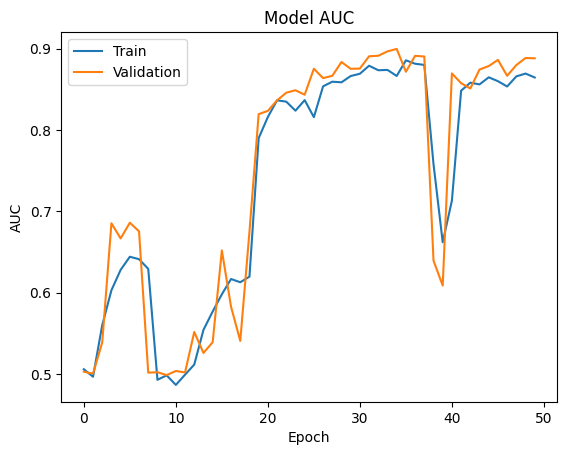

In [34]:
# Plot training & validation AUC values
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()